**Import Lib**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import re
import pickle
import operator
from scipy.sparse import csr_matrix
from pandas.api.types import is_numeric_dtype
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Firstly Load Dataset:**


In [3]:
books = pd.read_csv(r"/content/drive/MyDrive/Alma Better Capstone Project/Unsupervised ML- Book Recommendation System ./Books.csv", delimiter=';', error_bad_lines=False, encoding='ISO-8859-1', warn_bad_lines=False)
users = pd.read_csv(r"/content/drive/MyDrive/Alma Better Capstone Project/Unsupervised ML- Book Recommendation System ./Users.csv", delimiter=';', error_bad_lines=False, encoding='ISO-8859-1', warn_bad_lines=False)
ratings = pd.read_csv(r"/content/drive/MyDrive/Alma Better Capstone Project/Unsupervised ML- Book Recommendation System ./Book-Ratings.csv", delimiter=';', error_bad_lines=False, encoding='ISO-8859-1', warn_bad_lines=False)

**Books Dataset**

In [4]:
books.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
      dtype='object')

In [5]:
books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [6]:
#Drop Unwanted Columns
books=books[['ISBN','Book-Title','Book-Author','Year-Of-Publication','Publisher','Image-URL-L']]


In [7]:
books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-L            3
dtype: int64

In [8]:
books.describe()

ISBN      Book-Title      Book-Author  Year-Of-Publication  \
count       271360          271360           271359               271360   
unique      271360          242135           102023                  202   
top     0195153448  Selected Poems  Agatha Christie                 2002   
freq             1              27              632                13903   

        Publisher                                        Image-URL-L  
count      271358                                             271357  
unique      16807                                             271041  
top     Harlequin  http://images.amazon.com/images/P/225307649X.0...  
freq         7535                                                  2

In [9]:
books.head()

ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

            Book-Author Year-Of-Publication                   Publisher  \
0    Mark P. O. Morford                2002     Oxford University Press   
1  Richard Bruce Wright                2001       HarperFlamingo Canada   
2          Carlo D'Este                1991             HarperPerennial   
3      Gina Bari Kolata                1999        Farrar Straus Giroux   
4       E. J. W. Barber                1999  W. W. Norton &amp; Company   

                                         Image-URL-L  
0  http://images.amazon.com/images/P/0195153448.0...  
1  http://images.amazon.com/images/P/0002005018.0...  
2  http://images.amazon.com/images/P/0060973129.0...  
3  http://images.amazon.com/images/P/0374157065.0...  
4  http://images.amazon.com/images/P/0393045218.0...

**Featrue Engineering Change the columns name for better reliablity**

In [10]:
books.rename(columns={'Book-Title':'title','Book-Author':'author','Year-Of-Publication':'year','Publisher':'publisher','Image-URL-L':'url'},inplace=True)

In [11]:
books.head()

ISBN                                              title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

                 author  year                   publisher  \
0    Mark P. O. Morford  2002     Oxford University Press   
1  Richard Bruce Wright  2001       HarperFlamingo Canada   
2          Carlo D'Este  1991             HarperPerennial   
3      Gina Bari Kolata  1999        Farrar Straus Giroux   
4       E. J. W. Barber  1999  W. W. Norton &amp; Company   

                                                 url  
0  http://images.amazon.com/images/P/0195153448.0...  
1  http://images.amazon.com/images/P/0002005018.0...  
2  http://images.amazon.com/images/P/0060973129.0...  
3  http://images.amazon.com/images/P/0374157065.0...  
4  http://images.amazon.com/images/P/0393045218.0...

**Users Dataset**

In [12]:
users.head()

User-ID                            Location   Age
0        1                  nyc, new york, usa   NaN
1        2           stockton, california, usa  18.0
2        3     moscow, yukon territory, russia   NaN
3        4           porto, v.n.gaia, portugal  17.0
4        5  farnborough, hants, united kingdom   NaN

In [13]:
#Featrue Engineering Change the columns name for better reliablity

users.rename(columns={'User-ID':'user_id','Location':'location','Age':'age'},inplace=True)

In [14]:
users.head()

user_id                            location   age
0        1                  nyc, new york, usa   NaN
1        2           stockton, california, usa  18.0
2        3     moscow, yukon territory, russia   NaN
3        4           porto, v.n.gaia, portugal  17.0
4        5  farnborough, hants, united kingdom   NaN

In [15]:
users.describe()

user_id            age
count  278858.00000  168096.000000
mean   139429.50000      34.751434
std     80499.51502      14.428097
min         1.00000       0.000000
25%     69715.25000      24.000000
50%    139429.50000      32.000000
75%    209143.75000      44.000000
max    278858.00000     244.000000

In [16]:
mean_value=users['age'].mean()
users['age'].fillna(value=mean_value, inplace=True)

In [17]:
users.isnull().sum()

user_id     0
location    0
age         0
dtype: int64

In [18]:
#outlier data in Age column
users=users[users['age']<100]
users=users[users['age']>0]
users=users[users['location']!= 'n/a, n/a, n/a']
users.head()

user_id                            location        age
0        1                  nyc, new york, usa  34.751434
1        2           stockton, california, usa  18.000000
2        3     moscow, yukon territory, russia  34.751434
3        4           porto, v.n.gaia, portugal  17.000000
4        5  farnborough, hants, united kingdom  34.751434

In [19]:
for i in users:
    users['Country']=users.location.str.extract(r'\,+\s?(\w*\s?\w*)\"*$')

In [20]:
users.drop('location',axis=1,inplace=True)

In [21]:
users.head()

user_id        age         Country
0        1  34.751434             usa
1        2  18.000000             usa
2        3  34.751434          russia
3        4  17.000000        portugal
4        5  34.751434  united kingdom

In [22]:
users.isnull().sum()

user_id      0
age          0
Country    355
dtype: int64

In [23]:
users=users.dropna()

In [24]:
users.isnull().sum()

user_id    0
age        0
Country    0
dtype: int64

**Ratings Dataset**

In [25]:
ratings.head()

User-ID        ISBN  Book-Rating
0   276725  034545104X            0
1   276726  0155061224            5
2   276727  0446520802            0
3   276729  052165615X            3
4   276729  0521795028            6

In [26]:
ratings.rename(columns={'User-ID':'user_id','Book-Rating':'rating'},inplace=True)

In [27]:
ratings.head()

user_id        ISBN  rating
0   276725  034545104X       0
1   276726  0155061224       5
2   276727  0446520802       0
3   276729  052165615X       3
4   276729  0521795028       6

In [28]:
ratings.describe()

user_id        rating
count  1.149780e+06  1.149780e+06
mean   1.403864e+05  2.866950e+00
std    8.056228e+04  3.854184e+00
min    2.000000e+00  0.000000e+00
25%    7.034500e+04  0.000000e+00
50%    1.410100e+05  0.000000e+00
75%    2.110280e+05  7.000000e+00
max    2.788540e+05  1.000000e+01

In [29]:
ratings.isnull().sum()

user_id    0
ISBN       0
rating     0
dtype: int64

In [30]:
ratings['user_id'].value_counts()

11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
          ...  
116180        1
116166        1
116154        1
116137        1
276723        1
Name: user_id, Length: 105283, dtype: int64

In [31]:
ratings['user_id'].value_counts().shape

(105283,)

In [32]:
#Chaking Data shape
print("Books_dataset--->>>" , books.shape )
print("Users_dataset--->>>" , users.shape )
print("Ratings_dataset--->>>"  ,ratings.shape )


Books_dataset--->>> (271360, 6)
Users_dataset--->>> (277703, 3)
Ratings_dataset--->>> (1149780, 3)


**Only those people consider for more than rated are 50 Books**

In [33]:
x=ratings['user_id'].value_counts() > 50

In [34]:
x[x].shape


(3371,)

In [35]:
y=x[x].index

In [36]:
y

Int64Index([ 11676, 198711, 153662,  98391,  35859, 212898, 278418,  76352,
            110973, 235105,
            ...
            195079, 239486,  63506, 220911, 187613,  90105, 109040, 137803,
             83034, 190939],
           dtype='int64', length=3371)

In [37]:
ratings=ratings[ratings['user_id'].isin(y)]
ratings

user_id        ISBN  rating
173       276847  0446364193       0
174       276847  3257200552       5
175       276847  3379015180       0
176       276847  3404145909       8
177       276847  3404148576       8
...          ...         ...     ...
1149744   276688  0836236688      10
1149745   276688  0892966548      10
1149746   276688  1551669315       6
1149747   276688  1575660792       7
1149748   276688  1580600506       0

[765672 rows x 3 columns]

In [38]:
ratings.shape

(765672, 3)

In [39]:
ratings.head()

user_id        ISBN  rating
173   276847  0446364193       0
174   276847  3257200552       5
175   276847  3379015180       0
176   276847  3404145909       8
177   276847  3404148576       8

**Marge Datasets**

In [40]:
ratings_with_books=ratings.merge(books,on='ISBN')
ratings_with_books=users.merge(ratings_with_books,on='user_id')
ratings_with_books.head()

user_id   age   Country        ISBN  rating  \
0      183  27.0  portugal  2070567842       8   
1      183  27.0  portugal  225314696X       0   
2      183  27.0  portugal  8401422825       9   
3      183  27.0  portugal  8420639133       0   
4      183  27.0  portugal  8433920081       0   

                                               title                author  \
0        Folio Junior: L'histoire De Monsieur Sommer        Su>skind-Sempe   
1  Contes de fÃ?Â©es Ã?Â  l'usage des moyennes pe...            Boris Vian   
2                                     Fahrenheit 451          Ray Bradbury   
3                                    Temor y Temblor     Soren Kierkegaard   
4                                El Almuerzo Desnudo  William S. Burroughs   

   year                         publisher  \
0     0                Gallimard-Jeunesse   
1  2002                               LGF   
2  1993  Plaza &amp; Janes Editores, S.A.   
3  2001                           Alianza   
4  1995                          Anagrama   

                                                 url  
0  http://images.amazon.com/images/P/2070567842.0...  
1  http://images.amazon.com/images/P/225314696X.0...  
2  http://images.amazon.com/images/P/8401422825.0...  
3  http://images.amazon.com/images/P/8420639133.0...  
4  http://images.amazon.com/images/P/8433920081.0...

In [41]:
ratings_with_books.shape

(687099, 10)

In [42]:
number_rating=ratings_with_books.groupby('title')['rating'].count().reset_index()

In [43]:
number_rating.rename(columns={'rating':'number of ratings'},inplace=True)

In [44]:
final_rating=ratings_with_books.merge(number_rating,on='title')

In [45]:
final_rating.head()

user_id        age   Country        ISBN  rating  \
0      183  27.000000  portugal  2070567842       8   
1    73681  27.000000  portugal  2070567842       8   
2   201290  35.000000  portugal  2070567842       0   
3   269397  34.751434  portugal  2070567842       0   
4      183  27.000000  portugal  225314696X       0   

                                               title          author  year  \
0        Folio Junior: L'histoire De Monsieur Sommer  Su>skind-Sempe     0   
1        Folio Junior: L'histoire De Monsieur Sommer  Su>skind-Sempe     0   
2        Folio Junior: L'histoire De Monsieur Sommer  Su>skind-Sempe     0   
3        Folio Junior: L'histoire De Monsieur Sommer  Su>skind-Sempe     0   
4  Contes de fÃ?Â©es Ã?Â  l'usage des moyennes pe...      Boris Vian  2002   

            publisher                                                url  \
0  Gallimard-Jeunesse  http://images.amazon.com/images/P/2070567842.0...   
1  Gallimard-Jeunesse  http://images.amazon.com/images/P/2070567842.0...   
2  Gallimard-Jeunesse  http://images.amazon.com/images/P/2070567842.0...   
3  Gallimard-Jeunesse  http://images.amazon.com/images/P/2070567842.0...   
4                 LGF  http://images.amazon.com/images/P/225314696X.0...   

   number of ratings  
0                  4  
1                  4  
2                  4  
3                  4  
4                  1

**Only those Ratings consider for  more than 20 Ratings avilable in book**

In [46]:
final_rating=final_rating[final_rating['number of ratings']>=20]

In [47]:
final_rating.shape

(233725, 11)

In [48]:
#Drop Duplicates
final_rating.drop_duplicates(['user_id','title'],inplace=True)

In [49]:
final_rating.shape

(230525, 11)

In [50]:
final_rating.isnull().sum()

user_id              0
age                  0
Country              0
ISBN                 0
rating               0
title                0
author               0
year                 0
publisher            0
url                  0
number of ratings    0
dtype: int64

### **Exploratory Data Analysis**


Text(0.5, 1.0, 'Top 10 publisher')

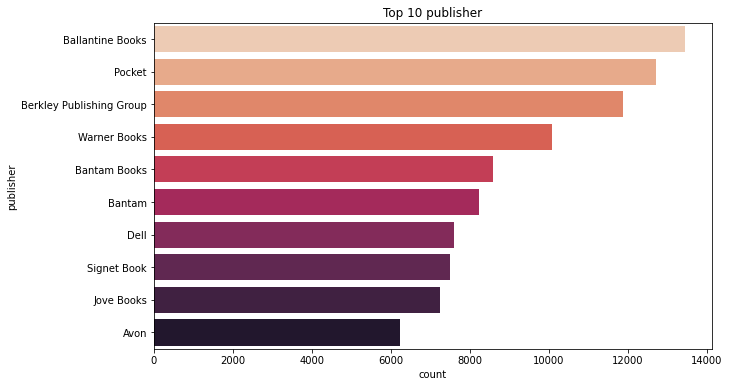

In [51]:
#Top 10 Publisher
plt.figure(figsize=(10,6))
sns.countplot(y='publisher',data=final_rating,order=pd.value_counts(final_rating['publisher']).iloc[:10].index,palette='rocket_r',)
plt.title('Top 10 publisher')

Text(0.5, 1.0, 'Top 10 Authors')

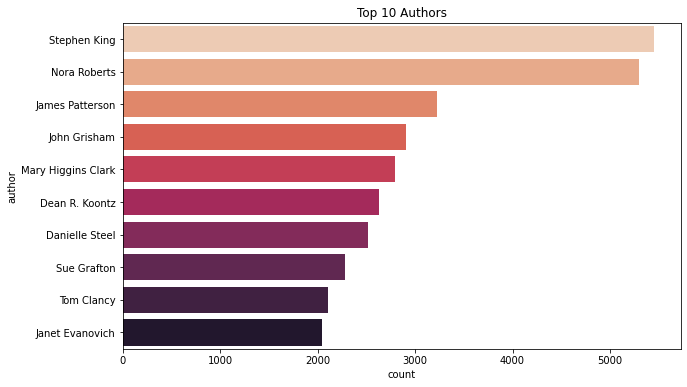

In [52]:
#Top 10 Authors
plt.figure(figsize=(10,6))
sns.countplot(y='author',data=final_rating,order=pd.value_counts(final_rating['author']).iloc[:10].index,palette='rocket_r',)
plt.title('Top 10 Authors')

Text(0.5, 1.0, 'Count rating')

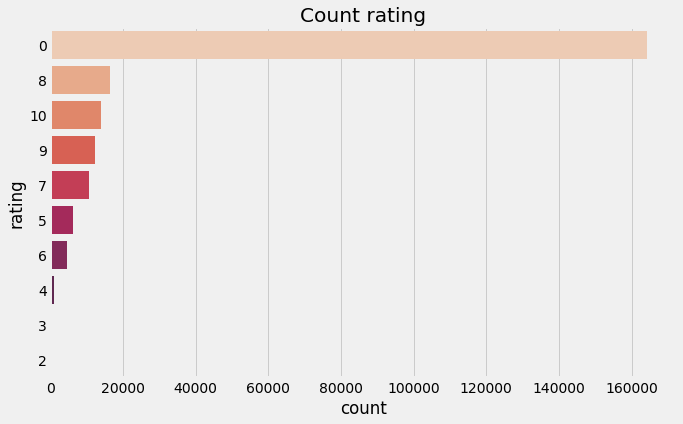

In [53]:
#Top 10 ratings
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,6))
sns.countplot(y='rating',data=final_rating,order=pd.value_counts(final_rating['rating']).iloc[:10].index,palette='rocket_r',)
plt.title('Count rating')

Text(0.5, 1.0, 'Explicit Ratings')

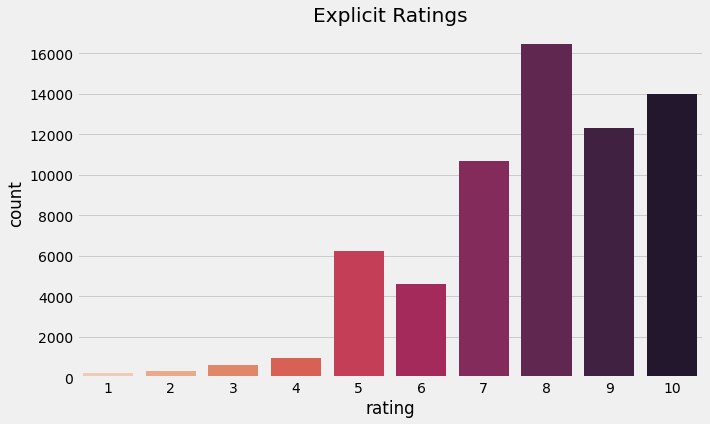

In [54]:
plt.figure(figsize=(10,6))
data = final_rating[final_rating['rating'] != 0]
sns.countplot(x="rating", data=data,palette='rocket_r')
plt.title("Explicit Ratings")

Text(0.5, 1.0, 'Top 10 books')

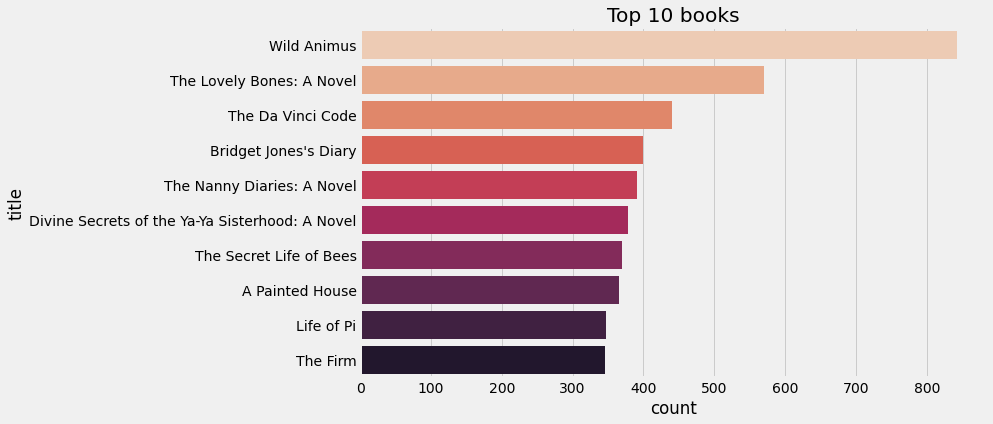

In [55]:
#Top 10 books
plt.figure(figsize=(10,6))
sns.countplot(y='title',data=final_rating,order=pd.value_counts(final_rating['title']).iloc[:10].index,palette='rocket_r',)
plt.title('Top 10 books')

Text(0.5, 1.0, 'Age Distribution Plot')

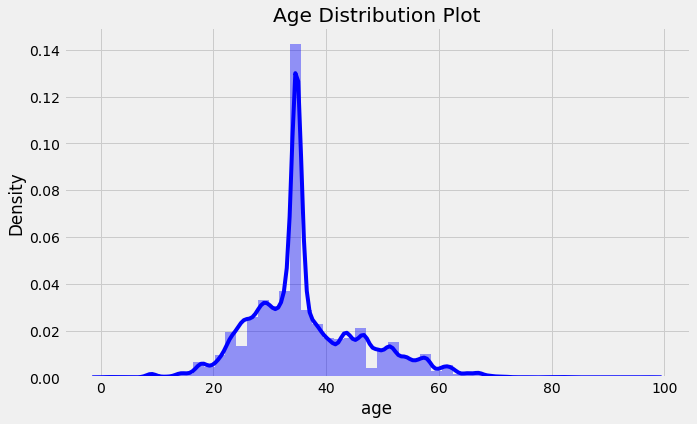

In [56]:
#Age Distribution
plt.figure(figsize=(10,6))
sns.distplot(final_rating['age'],color='blue')
plt.title('Age Distribution Plot')

Text(0.5, 1.0, 'No of readers from each country (Top 10)')

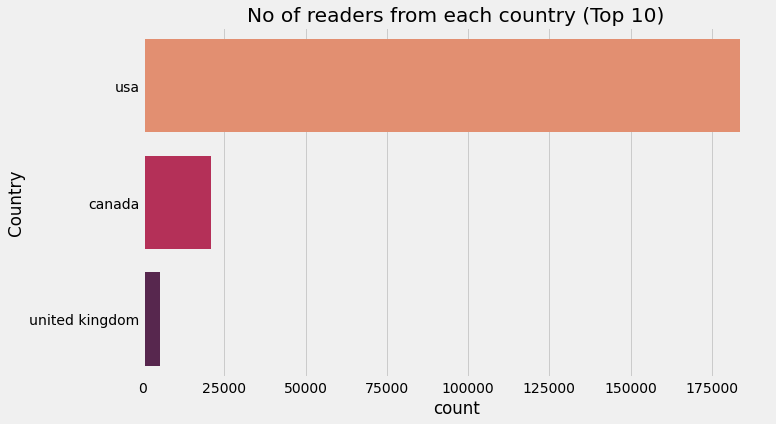

In [57]:
#most  Active Reader Country
plt.figure(figsize=(10,6))
sns.countplot(y="Country", data=final_rating, order=final_rating['Country'].value_counts().index[0:3],palette='rocket_r')
plt.title("No of readers from each country (Top 10)")

In [58]:
book_pivot=final_rating.pivot_table(columns='user_id',index='title',values='rating')

In [59]:
book_pivot.shape

(4812, 3279)

In [60]:
book_pivot.fillna(0,inplace=True)

In [61]:
book_pivot

user_id                                             183     243     254     \
title                                                                        
'Salem's Lot                                           0.0     0.0     0.0   
10 Lb. Penalty                                         0.0     0.0     0.0   
101 Dalmatians                                         0.0     0.0     0.0   
14,000 Things to Be Happy About                        0.0     0.0     0.0   
16 Lighthouse Road                                     0.0     0.0     0.0   
...                                                    ...     ...     ...   
\ Lamb to the Slaughter and Other Stories (Peng...     0.0     0.0     0.0   
\O\" Is for Outlaw"                                    0.0     0.0     0.0   
\Surely You're Joking, Mr. Feynman!\": Adventur...     0.0     0.0     0.0   
e                                                      0.0     0.0     0.0   
stardust                                               0.0     0.0     0.0   

user_id                                             507     626     638     \
title                                                                        
'Salem's Lot                                           0.0     0.0     0.0   
10 Lb. Penalty                                         0.0     0.0     0.0   
101 Dalmatians                                         0.0     0.0     0.0   
14,000 Things to Be Happy About                        0.0     0.0     0.0   
16 Lighthouse Road                                     0.0     0.0     0.0   
...                                                    ...     ...     ...   
\ Lamb to the Slaughter and Other Stories (Peng...     0.0     0.0     0.0   
\O\" Is for Outlaw"                                    0.0     0.0     0.0   
\Surely You're Joking, Mr. Feynman!\": Adventur...     0.0     0.0     0.0   
e                                                      0.0     0.0     0.0   
stardust                                               0.0     0.0     0.0   

user_id                                             643     741     882     \
title                                                                        
'Salem's Lot                                           0.0     0.0     0.0   
10 Lb. Penalty                                         0.0     0.0     0.0   
101 Dalmatians                                         0.0     0.0     0.0   
14,000 Things to Be Happy About                        0.0     0.0     0.0   
16 Lighthouse Road                                     0.0     0.0     0.0   
...                                                    ...     ...     ...   
\ Lamb to the Slaughter and Other Stories (Peng...     0.0     0.0     0.0   
\O\" Is for Outlaw"                                    0.0     0.0     0.0   
\Surely You're Joking, Mr. Feynman!\": Adventur...     0.0     0.0     0.0   
e                                                      0.0     0.0     0.0   
stardust                                               0.0     0.0     0.0   

user_id                                             929     ...  277928  \
title                                                       ...           
'Salem's Lot                                           0.0  ...     0.0   
10 Lb. Penalty                                         0.0  ...     0.0   
101 Dalmatians                                         0.0  ...     0.0   
14,000 Things to Be Happy About                        8.0  ...     0.0   
16 Lighthouse Road                                     0.0  ...     0.0   
...                                                    ...  ...     ...   
\ Lamb to the Slaughter and Other Stories (Peng...     0.0  ...     0.0   
\O\" Is for Outlaw"                                    0.0  ...     0.0   
\Surely You're Joking, Mr. Feynman!\": Adventur...     0.0  ...     0.0   
e                                                      0.0  ...     0.0   
stardust                                               

In [62]:
from scipy.sparse import csr_matrix
book_sparse=csr_matrix(book_pivot)

In [63]:
type(book_sparse)

scipy.sparse.csr.csr_matrix

## **Recommendation Systems**

### **1.Content Based Filtering**

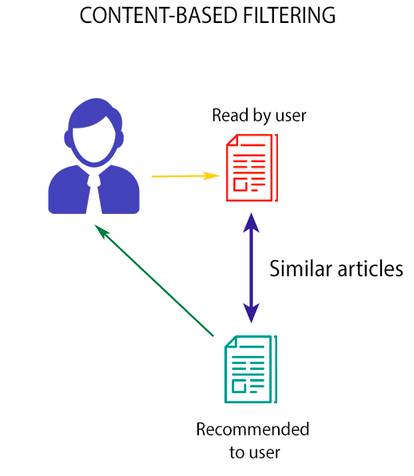

**Rating Based Recommendation Systems**

In [64]:
#So Let's find books for top Rating based.
x=final_rating.sort_values(by=['rating'], ascending=False)
Rating_Based=x['title'].unique()
print("Ratings_Based top 5 Books\n")
x=Rating_Based[:5]
x


Ratings_Based top 5 Books



array(['Almost Heaven', 'Long After Midnight', 'Persuasion',
       'Anne Frank: The Diary of a Young Girl', 'Acceptable Risk'],
      dtype=object)

**Popularity_Based Recommendation Systems**

In [65]:
#So Let's find books for top Rating based.
x=final_rating.sort_values(by=['number of ratings'], ascending=False)
Popularity_Based=x['title'].unique()
print("Popularity_Based top 5 Books\n")
Popularity_Based[:5]

Popularity_Based top 5 Books



array(['Wild Animus', 'The Lovely Bones: A Novel', 'The Da Vinci Code',
       "Bridget Jones's Diary", 'The Nanny Diaries: A Novel'],
      dtype=object)

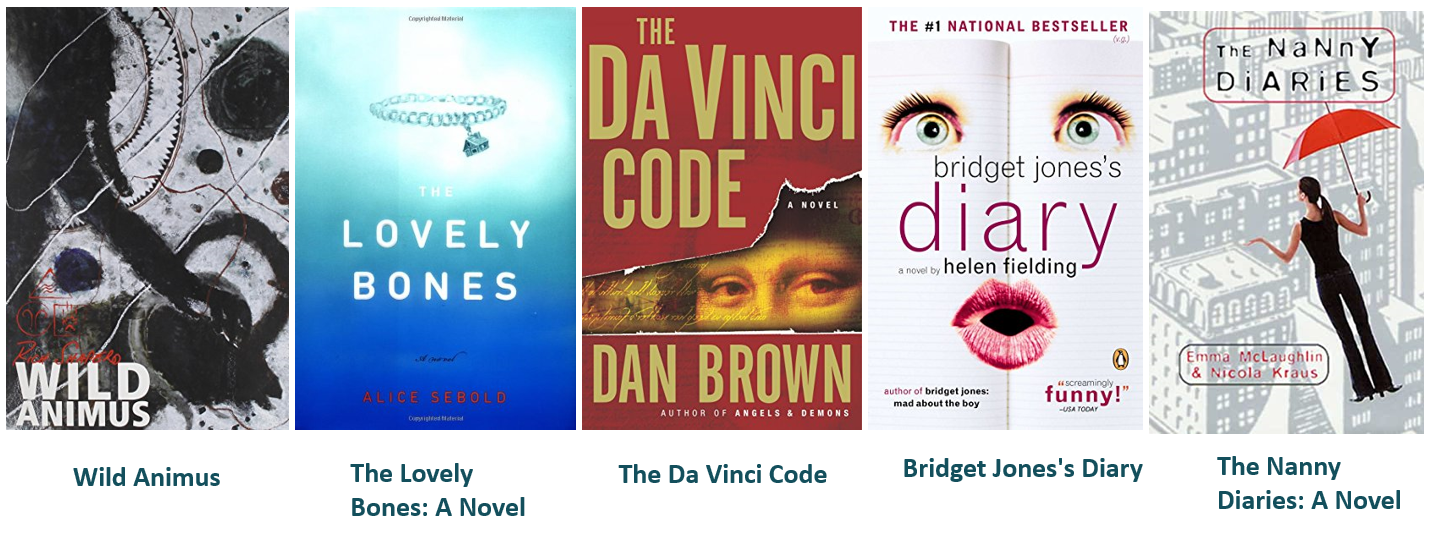

**Year_Based Books Popular Recommendation Systems**

In [66]:
Year=int(input("Entre the Year "))
x=final_rating[final_rating['year']== Year]
data=x.sort_values(by=['number of ratings','rating'], ascending=False)
Books_Popular_Year=data['title'].unique()
print("Top 5 Books_Popular_this_Year \n")
Books_Popular_Year[:5]

##So Let's find Popular books in year 1981 ?


Entre the Year 1981
Top 5 Books_Popular_this_Year 



array(['The Testament', 'Interview with the Vampire', 'Whispers',
       'Outlander', 'The Gift'], dtype=object)

**Author_Based Recommendation Systems**

In [67]:
Author=str(input("Entre the Author Name\n"))
x=final_rating[final_rating['author']== Author]
data=x.sort_values(by=['number of ratings','rating'], ascending=False)
Books_Popular_Author=data['title'].unique()
print("Top 5 Popular_Books_this_Author\n")
Books_Popular_Author[:5]

##So Let's find Popular books in Author ?
# Example : James Patterson

Entre the Author Name
James Patterson
Top 5 Popular_Books_this_Author



array(['1st to Die: A Novel', 'When the Wind Blows', 'Violets Are Blue',
       "Suzanne's Diary for Nicholas", 'The Beach House'], dtype=object)

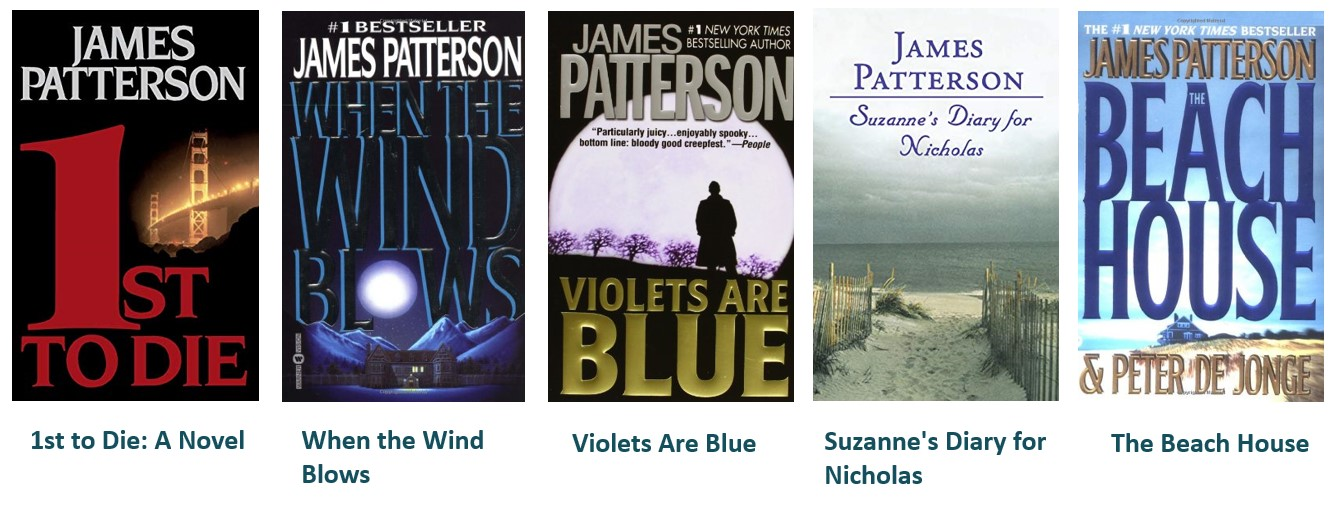

**Country_Based Recommendation Systems**

In [68]:
Country=str(input("Entre the Country Name\n"))
x=final_rating[final_rating['Country']== Country]
data=x.sort_values(by=['number of ratings','rating'], ascending=False)
Books_Popular_Author=data['title'].unique()
print("Top 5 Popular_Books_this_Country\n")
Books_Popular_Author[:5]

#Example= usa

Entre the Country Name
usa
Top 5 Popular_Books_this_Country



array(['Wild Animus', 'The Lovely Bones: A Novel', 'The Da Vinci Code',
       "Bridget Jones's Diary", 'The Nanny Diaries: A Novel'],
      dtype=object)

**Books by same author, publisher of given book name**

In [69]:
def printBook(k, n):
    z = k['title'].unique()
    for x in range(len(z)):
        print(z[x])
        if x >= n-1:
            break

In [70]:
def get_books(dataframe, name, n):
    print("\nBooks by same Author:\n")
    au = dataframe['author'].unique()

    data = final_rating[final_rating['title'] != name]

    if au[0] in list(data['author'].unique()):
        k2 = data[data['author'] == au[0]]
    k2 = k2.sort_values(by=['rating'])
    printBook(k2, n)

    print("\n\nBooks by same Publisher:\n")
    au = dataframe['publisher'].unique()
    if au[0] in list(data['publisher'].unique()):
        k2 = pd.DataFrame(data[data['publisher'] == au[0]])
    k2=k2.sort_values(by=['rating']) 
    printBook(k2, n)

In [71]:
bookName = input("Enter a book name: ")
number = int(input("Enter number of books to recommend: "))

#example= Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))

if bookName in list(final_rating['title'].unique()):
    d = final_rating[final_rating['title'] == bookName]
    get_books(d, bookName, number)
else:
    print("Invalid Book Name!!")

Enter a book name: Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Enter number of books to recommend: 5

Books by same Author:

Harry Potter and the Chamber of Secrets Postcard Book
Harry Potter and the Order of the Phoenix (Book 5)
Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Chamber of Secrets (Book 2)


Books by same Publisher:

Harry Potter and the Chamber of Secrets Postcard Book
Harry Potter and the Sorcerer's Stone (Book 1)
Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Goblet of Fire (Book 4)


### **2.Collaborative Filtering**

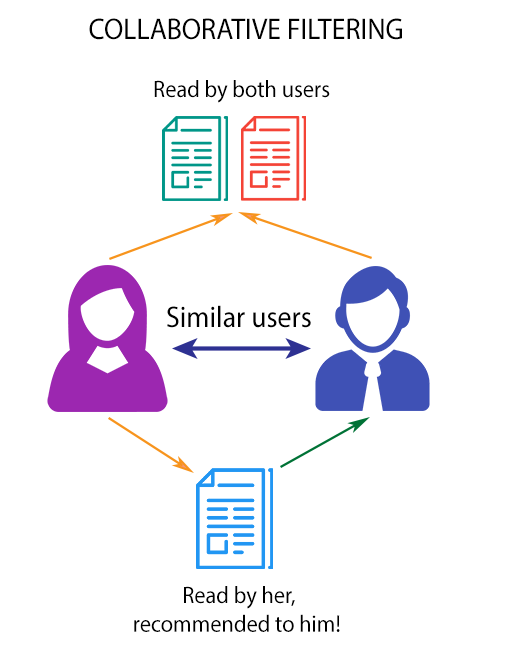

**Collaborative Filtering (User-Item Filtering)**

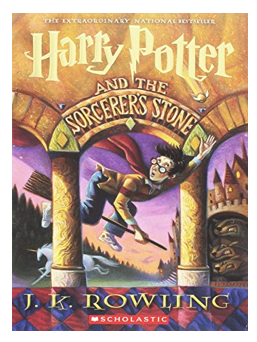

In [72]:
df = pd.DataFrame(final_rating['title'].value_counts())
df['number of ratings'] = df['title']
df['title'] = df.index
df.reset_index(level=0, inplace=True)
df = df.drop('index',axis=1)

df = final_rating.merge(df, left_on = 'title', right_on = 'title', how = 'left')
df = df.drop(['publisher','year','age','Country','url'], axis=1)
popularity_threshold = 50
popular_book = df[df['number of ratings_x'] >= popularity_threshold]
popular_book = popular_book.reset_index(drop = True)

In [73]:
testdf = pd.DataFrame()
testdf['ISBN'] = popular_book['ISBN']
testdf['Book-Rating'] = popular_book['rating']
testdf['User-ID'] = popular_book['user_id']
testdf = testdf[['User-ID','Book-Rating']].groupby(testdf['ISBN'])

In [74]:
listOfDictonaries=[]
indexMap = {}
reverseIndexMap = {}
ptr=0

for groupKey in testdf.groups.keys():
    tempDict={}
    groupDF = testdf.get_group(groupKey)
    for i in range(0,len(groupDF)):
        tempDict[groupDF.iloc[i,0]] = groupDF.iloc[i,1]
    indexMap[ptr]=groupKey
    reverseIndexMap[groupKey] = ptr
    ptr=ptr+1
    listOfDictonaries.append(tempDict)

dictVectorizer = DictVectorizer(sparse=True)
vector = dictVectorizer.fit_transform(listOfDictonaries)
pairwiseSimilarity = cosine_similarity(vector)

In [75]:
def printBookDetails(bookID):
    print(final_rating[final_rating['ISBN']==bookID]['title'].values[0])

def getTopRecommandations(bookID):
    collaborative = []
    row = reverseIndexMap[bookID]
    print("Input Book:")
    printBookDetails(bookID)
    
    print("\nRECOMMENDATIONS:\n")
    
    mn = 0
    similar = []
    for i in np.argsort(pairwiseSimilarity[row])[:-2][::-1]:
          if final_rating[final_rating['ISBN']==indexMap[i]]['title'].values[0] not in similar:
                if mn>=number:
                      break
                mn+=1
                similar.append(final_rating[final_rating['ISBN']==indexMap[i]]['title'].values[0])
                printBookDetails(indexMap[i])
                collaborative.append(final_rating[final_rating['ISBN']==indexMap[i]]['title'].values[0])
    return collaborative

In [76]:
k = list(final_rating['title'])
m = list(final_rating['ISBN'])

collaborative = getTopRecommandations(m[k.index(bookName)])

Input Book:
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))

RECOMMENDATIONS:

Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Order of the Phoenix (Book 5)
Fried Green Tomatoes at the Whistle Stop Cafe
Harry Potter and the Chamber of Secrets (Book 2)


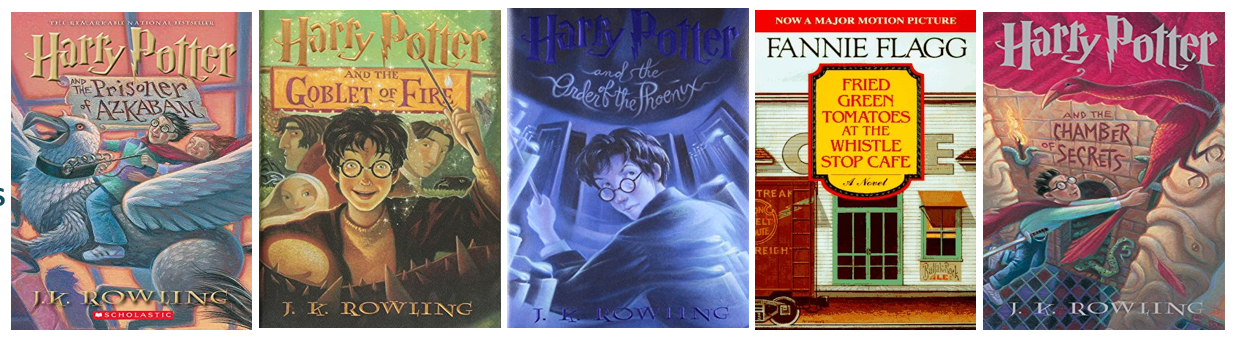

**Correlation Based**

In [77]:
popularity_threshold = 50

user_count = final_rating['user_id'].value_counts()
data = final_rating[final_rating['user_id'].isin(user_count[user_count >= popularity_threshold].index)]
rat_count = data['rating'].value_counts()
data = data[data['rating'].isin(rat_count[rat_count >= popularity_threshold].index)]

matrix = data.pivot_table(index='user_id', columns='ISBN', values = 'rating').fillna(0)

In [78]:
average_rating = pd.DataFrame(final_rating.groupby('ISBN')['rating'].mean())
average_rating['ratingCount'] = pd.DataFrame(ratings.groupby('ISBN')['rating'].count())
average_rating.sort_values('ratingCount', ascending=False).head()

rating  ratingCount
ISBN                             
0971880107  0.528504          844
0316666343  3.485965          574
0385504209  3.811628          434
0060928336  2.380697          375
0312195516  3.371681          341

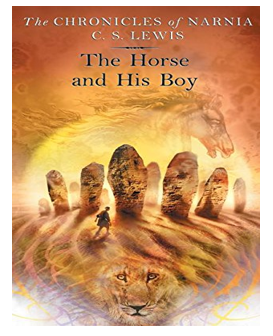

In [79]:
bookName = input("Enter a book name: ")

#example= Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))

isbn = books.loc[books['title'] == bookName].reset_index(drop = True).iloc[0]['ISBN']
row = matrix[isbn]
correlation = pd.DataFrame(matrix.corrwith(row), columns = ['Pearson Corr'])
corr = correlation.join(average_rating['ratingCount'])

res = corr.sort_values('Pearson Corr', ascending=False).head(number+1)[1:].index
corr_books = pd.merge(pd.DataFrame(res, columns = ['ISBN']), books, on='ISBN')
print("\n Recommended Books: \n")
corr_books['title']

Enter a book name: Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))

 Recommended Books: 



0     Harry Potter and the Chamber of Secrets (Book 2)
1    Harry Potter and the Prisoner of Azkaban (Book 3)
2         Harry Potter and the Goblet of Fire (Book 4)
3    Harry Potter and the Order of the Phoenix (Boo...
4                                           Love Story
Name: title, dtype: object

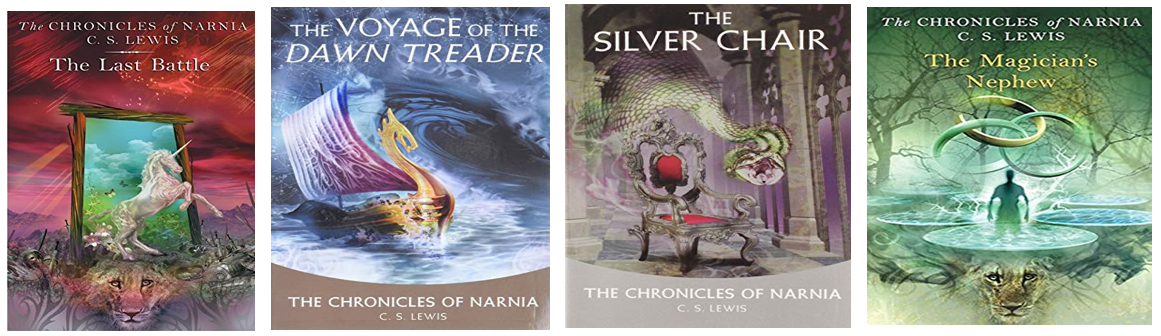

**Nearest Neighbours Based**

In [80]:
from sklearn.neighbors import NearestNeighbors
model=NearestNeighbors(algorithm='brute',metric='cosine')

In [81]:
model.fit(book_sparse)

NearestNeighbors(algorithm='brute', metric='cosine')

In [82]:
distances,suggestions= model.kneighbors(book_pivot.iloc[277, :].values.reshape(1,-1))

In [83]:
suggestions

array([[ 277, 1441, 4588, 4537, 3667]])

In [84]:
for i in range(len(suggestions)):
  print(book_pivot.index[suggestions[i]])

Index(['An Inconvenient Woman', 'Golden Cup', 'Voice of the Heart',
       'Under Gemini', 'The Fig Eater : A Novel'],
      dtype='object', name='title')


In [85]:
book_pivot.index[400]

'Barn Blind'

In [86]:
np.where(book_pivot.index == 'Animal Farm')[0][0]

310

**So Let's find books similar to Harry Potter and the Prisoner of Azkaban (Book 3)**

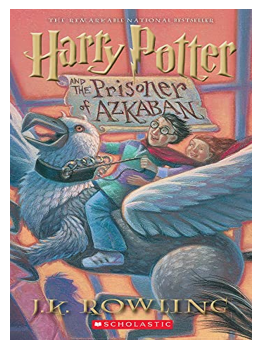

In [87]:
Books_Name=str(input("Pls Entre the Book Name  \n"))

def recommend_book(book_name):
  book_id=np.where(book_pivot.index ==book_name)[0][0]
  distances,suggestions= model.kneighbors(book_pivot.iloc[book_id, :].values.reshape(1,-1))

  for i in range(len(suggestions)):
    if i==0:
      print("The Suggestions for",book_name,'are :\n\n')
      if not i:
        print(book_pivot.index[suggestions[i]])
recommend_book(Books_Name)
#Example-Books Name - "Harry Potter and the Prisoner of Azkaban (Book 3)"

Pls Entre the Book Name  
Harry Potter and the Prisoner of Azkaban (Book 3)
The Suggestions for Harry Potter and the Prisoner of Azkaban (Book 3) are :


Index(['Harry Potter and the Prisoner of Azkaban (Book 3)',
       'Harry Potter and the Goblet of Fire (Book 4)',
       'Harry Potter and the Chamber of Secrets (Book 2)',
       'Harry Potter and the Sorcerer's Stone (Book 1)',
       'Harry Potter and the Order of the Phoenix (Book 5)'],
      dtype='object', name='title')


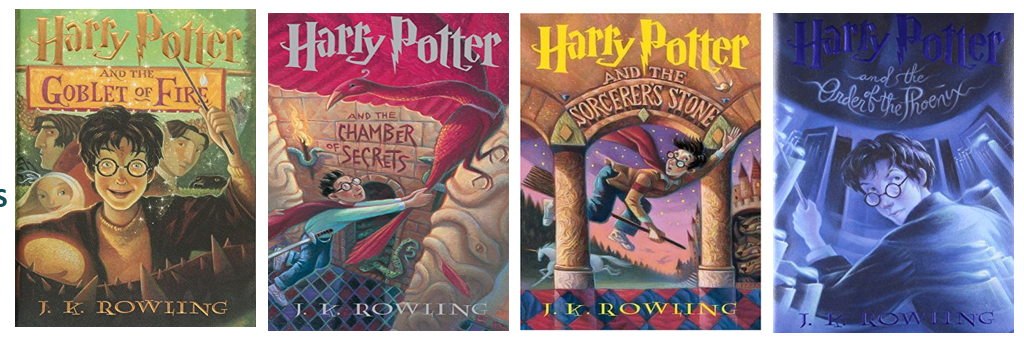

**Cool..!!**

### **Conclusion**
* In EDA, the Top-10 most rated books were essentially novels. Books like The Wild Animus and The Lovely Bones: A Novel .
*  Majority of the readers were of the age bracket 20-50 and most of them came from North American and European countries namely USA, Canada, UK.
*  If we look at the ratings distribution, most of the books have high ratings with maximum books being rated 8. Ratings below 5 are few in number.
* Author with the most books was Stephen King, Nora Roberts and james Patterson. 
* A recommendation system helps an organization to create loyal customers.
The recommendation system today are very powerful that they can handle the
new customer too who has visited the site for the first time. They recommend
the products which are currently trending or highly rated and they can also
recommend the products which bring maximum profitto the company.